# Data Cleaning

First, we load in the data and do some data cleaning:

* Parsing datetimes
* Creating year, month, hour, halfhour columns, etc.
* Resampling/backfilling the settlements data to the right frequency for later use

In [1]:
import pandas as pd
import numpy as np
import warnings
from pandasql import sqldf
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import preprocessing
warnings.filterwarnings('ignore')


def parse_dates(filename):
    df = pd.read_csv(filename, index_col='Date', parse_dates=True)
    df.index = df.index + pd.to_timedelta((df['HalfHour'])*30, unit='minutes')
    df['Date'] = df.index
    df['Year'] = df.index.year.astype(int)
    df['Month'] = df.index.month.astype(int)
    df['Hour'] = df.index.hour.astype(int)
    df['Day'] = df.index.dayofweek.astype(int) + 1
    cols = df.columns.tolist()
    df =  df[cols[-5:] + cols[:-5]]
    df.dropna(inplace=True, axis=1)

    return df

def parse_settlements(filename):
    df = pd.read_csv(filename, parse_dates=True).dropna(axis=1)
    df['StartDelivery'] = pd.to_datetime(df['StartDelivery'], format='%d/%m/%Y')
    df['EndDelivery'] = pd.to_datetime(df['EndDelivery'], format='%d/%m/%Y')
    df.index = df.EndDelivery
    df = df.resample('M').bfill()
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    return df[['Year','Month','SettlementPrice','Unit']]

spot = parse_dates('SpotPrices_EMC.csv').iloc[:-1,:]
consumption = parse_dates('Consumption.csv')
consumption['Consumption'] = consumption['Consumption']/1e3
consumption['Unit'] = 'MWh'
settlements = parse_settlements('Settlements_SGX.csv')

In [2]:
spot

,Date,Year,Month,Hour,Day,HalfHour,Price,Unit,TotalSystemDemandMW,Unit.1,TotalSystemDemandMWh,Unit.2
2022-01-01 00:30:00,2022-01-01 00:30:00,2022,1,0,6,1,205.61,SGD/MWh,5585.018,MW,2792.5090,MWh
2022-01-01 01:00:00,2022-01-01 01:00:00,2022,1,1,6,2,202.32,SGD/MWh,5482.432,MW,2741.2160,MWh
2022-01-01 01:30:00,2022-01-01 01:30:00,2022,1,1,6,3,155.84,SGD/MWh,5415.401,MW,2707.7005,MWh
2022-01-01 02:00:00,2022-01-01 02:00:00,2022,1,2,6,4,155.73,SGD/MWh,5377.600,MW,2688.8000,MWh
2022-01-01 02:30:00,2022-01-01 02:30:00,2022,1,2,6,5,120.85,SGD/MWh,5332.805,MW,2666.4025,MWh
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:30:00,2023-12-31 21:30:00,2023,12,21,7,43,106.29,SGD/MWh,6134.352,MW,3067.1760,MWh
2023-12-31 22:00:00,2023-12-31 22:00:00,2023,12,22,7,44,102.89,SGD/MWh,6029.629,MW,3014.8145,MWh
2023-12-31 22:30:00,2023-12-31 22:30:00,2023,12,22,7,45,102.26,SGD/MWh,5906.721,MW,2953.3605,MWh
2023-12-31 23:00:00,2023-12-31 23:00:00,2023,12,23,7,46,101.23,SGD/MWh,5801.794,MW,2900.8970,MWh


In [3]:
consumption

,Date,Year,Month,Hour,Day,HalfHour,ConnectionId,Consumption,Unit
2023-01-09 00:30:00,2023-01-09 00:30:00,2023,1,0,1,1,ae3e61db-a623-4cee-acf1-d5a31360886f,1.270000,MWh
2023-01-09 01:00:00,2023-01-09 01:00:00,2023,1,1,1,2,ae3e61db-a623-4cee-acf1-d5a31360886f,1.275000,MWh
2023-01-09 01:30:00,2023-01-09 01:30:00,2023,1,1,1,3,ae3e61db-a623-4cee-acf1-d5a31360886f,1.260000,MWh
2023-01-09 02:00:00,2023-01-09 02:00:00,2023,1,2,1,4,ae3e61db-a623-4cee-acf1-d5a31360886f,1.255000,MWh
2023-01-09 02:30:00,2023-01-09 02:30:00,2023,1,2,1,5,ae3e61db-a623-4cee-acf1-d5a31360886f,1.265000,MWh
...,...,...,...,...,...,...,...,...,...
2023-08-31 22:00:00,2023-08-31 22:00:00,2023,8,22,4,44,1afef70d-f9c6-4304-9faf-841ad89d9256,0.000172,MWh
2023-08-31 22:30:00,2023-08-31 22:30:00,2023,8,22,4,45,1afef70d-f9c6-4304-9faf-841ad89d9256,0.000170,MWh
2023-08-31 23:00:00,2023-08-31 23:00:00,2023,8,23,4,46,1afef70d-f9c6-4304-9faf-841ad89d9256,0.000170,MWh
2023-08-31 23:30:00,2023-08-31 23:30:00,2023,8,23,4,47,1afef70d-f9c6-4304-9faf-841ad89d9256,0.000172,MWh


In [4]:
settlements

,Year,Month,SettlementPrice,Unit
EndDelivery,,,,
2024-01-31,2024,1,165.00,SGD/MWh
2024-02-29,2024,2,165.00,SGD/MWh
2024-03-31,2024,3,165.00,SGD/MWh
2024-04-30,2024,4,165.00,SGD/MWh
2024-05-31,2024,5,165.00,SGD/MWh
2024-06-30,2024,6,165.00,SGD/MWh
2024-07-31,2024,7,155.26,SGD/MWh
2024-08-31,2024,8,155.26,SGD/MWh
2024-09-30,2024,9,155.26,SGD/MWh


# Q1

`pandasql` package uses `SQLite` syntax.


## SQL



In [5]:
pysqldf = lambda q: sqldf(q, globals())

q1 = """
    SELECT 
        strftime('%Y', Date) AS year, 
        strftime('%m', Date) AS month, 
        AVG(Price) AS average_price, 
        MIN(Price) AS min_price, 
        MAX(Price) AS max_price, 
        AVG(TotalSystemDemandMW) AS average_demand, 
        MIN(TotalSystemDemandMW) AS min_demand, 
        MAX(TotalSystemDemandMW) AS max_demand
    FROM 
        spot
    WHERE 
        strftime('%Y', Date) IN ('2022', '2023')
    GROUP BY 
        year, 
        month
    LIMIT
        10;
"""

a1 = pysqldf(q1)
a1

,year,month,average_price,min_price,max_price,average_demand,min_demand,max_demand
0,2022,01,413.454338,100.37,3141.22,6273.356804,5176.603,7282.119
1,2022,02,256.370446,100.34,2125.20,6205.418952,5114.513,7224.203
2,2022,03,306.078898,102.48,3801.01,6304.240809,5052.726,7245.633
3,2022,04,356.293618,87.58,4249.34,6312.693805,5155.142,7267.053
4,2022,05,320.815625,100.42,4145.17,6407.960992,5217.441,7370.972
5,2022,06,241.624972,103.94,2494.04,6330.553424,5232.093,7252.140
6,2022,07,332.871398,100.37,4499.99,6409.692307,5185.375,7306.521
7,2022,08,224.832910,52.48,2214.56,6347.876476,5281.505,7234.511
8,2022,09,262.814743,104.38,2694.66,6338.091515,5237.416,7256.170
9,2022,10,289.591935,102.06,4238.52,6268.963759,5237.724,7315.035


# Q2




I first groupby `Month`, `Weekday`, `HalfHour`, then calculate the mean values. To normalize, we must decide on a _time frame_ and _method_.

For time frame, I normalize across each day, i.e by 48 half-hour intervals. For method:

* `MaxNorm` - Divide each half hour interval by the maximum price of that day
* `FracNorm` - Divide each half hour interval by the sum of prices of that day
* `ZNorm` - Z-score each half hour interval with the mean and std of that day


In actual SQL, I would use CTEs to store the results of `raw_q` and `norm_q` before joining them together.

The SQL below calculates `MaxNorm` and `FracNorm`.

In [6]:
raw_q = """
    SELECT
        strftime('%m', Date) AS Month,
        strftime('%w', Date) AS Day,
        HalfHour,
        AVG(Price) as Price
    FROM
        spot
    GROUP BY
        Month,
        Day,
        HalfHour
"""


norm_q = """
    SELECT 
        Month, 
        Day, 
        MIN(Price) AS MinPrice, 
        MAX(Price) AS MaxPrice,
        SUM(Price) AS SumPrice,
        AVG(Price) AS StdPrice
    FROM 
        raw
    GROUP BY 
        Month, 
        Day
"""

join_q = """
    SELECT
        r.Month,
        r.Day,
        r.HalfHour,
        r.Price,
        r.Price/m.MaxPrice AS MaxNorm,
        r.Price/m.SumPrice as FracNorm
    FROM
        raw r
    INNER JOIN
        minmax m ON r.Month = m.Month AND r.Day = m.Day
"""

raw = pysqldf(raw_q)
minmax = pysqldf(norm_q)
n_price = pysqldf((join_q))
n_price[['Month','Day','HalfHour']] = n_price[['Month','Day','HalfHour']].astype(int)

In [7]:
n_price

,Month,Day,HalfHour,Price,MaxNorm,FracNorm
0,1,1,1,349.228000,0.863511,0.026496
1,1,1,2,336.342000,0.831649,0.025519
2,1,1,3,189.147000,0.467690,0.014351
3,1,1,4,158.491000,0.391889,0.012025
4,1,1,5,157.737000,0.390025,0.011968
...,...,...,...,...,...,...
4027,12,0,44,172.930000,0.733901,0.023922
4028,12,0,45,163.004444,0.691778,0.022549
4029,12,0,46,151.040000,0.641002,0.020894
4030,12,0,47,151.278889,0.642016,0.020927


The same normalization can be done in Pandas in a much easier fashion:

In [8]:
def group(df):
    return df.groupby(['Month', 'Day']).Price


n_price = pd.DataFrame(spot.groupby(['Month','Day','HalfHour']).Price.mean()).reset_index()

n_price['MaxNorm'] = group(n_price).transform(lambda x: x/x.max())
n_price['FracNorm'] = group(n_price).transform(lambda x: x/x.sum())
n_price['ZNorm'] = group(n_price).transform(lambda x: zscore(x, ddof=1))
n_price['std'] = group(n_price).transform(lambda x: x.std())

<AxesSubplot: title={'center': 'Z Norm'}>

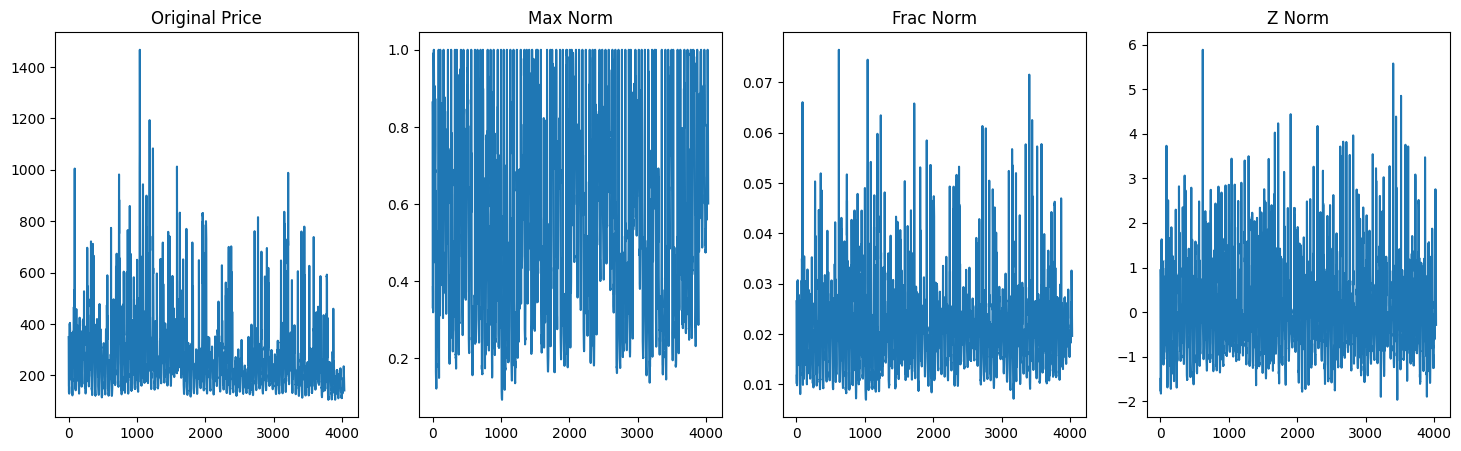

In [9]:
fig,ax = plt.subplots(1,4, figsize=(18,5))

n_price.Price.plot(ax=ax[0], title='Original Price')
n_price.MaxNorm.plot(ax=ax[1], title='Max Norm')
n_price.FracNorm.plot(ax=ax[2], title= 'Frac Norm')
n_price.ZNorm.plot(ax=ax[3], title='Z Norm')

<AxesSubplot: title={'center': 'Z Norm'}, ylabel='Frequency'>

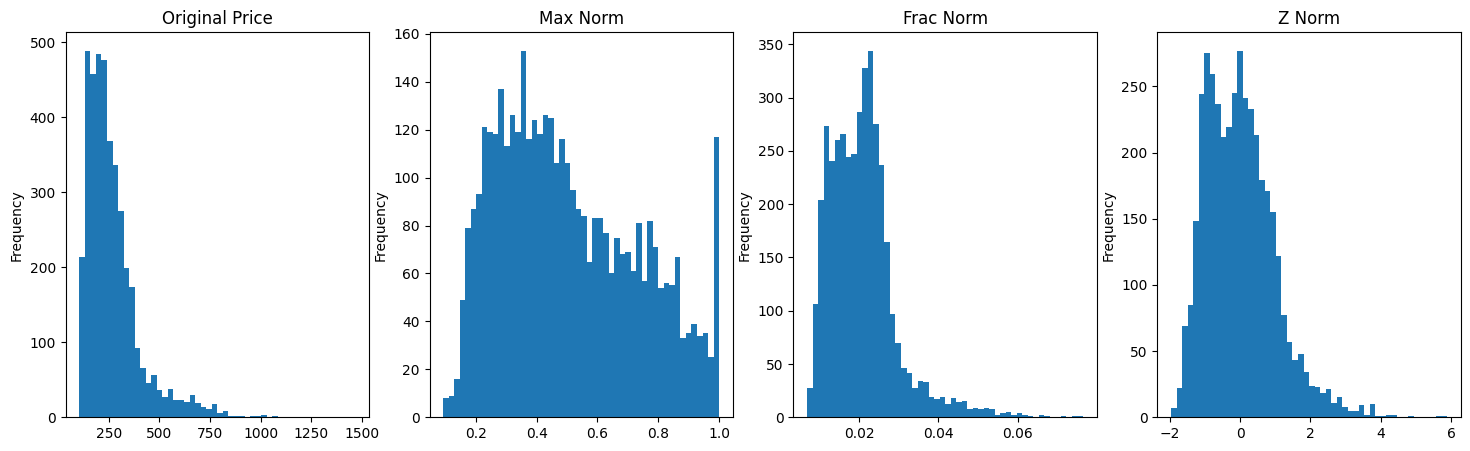

In [10]:
fig,ax = plt.subplots(1,4, figsize=(18,5))

n_price.Price.plot(kind='hist',bins=50,ax=ax[0], title='Original Price')
n_price.MaxNorm.plot(kind='hist',bins=50, ax=ax[1], title='Max Norm')
n_price.FracNorm.plot(kind='hist',bins=50,ax=ax[2], title= 'Frac Norm')
n_price.ZNorm.plot(kind='hist',bins=50,ax=ax[3], title='Z Norm')

# Q3

To determine which ID is which, we can look at the mean consumption patterns on a daily basis (over a week) and hourly basis (over 24h):

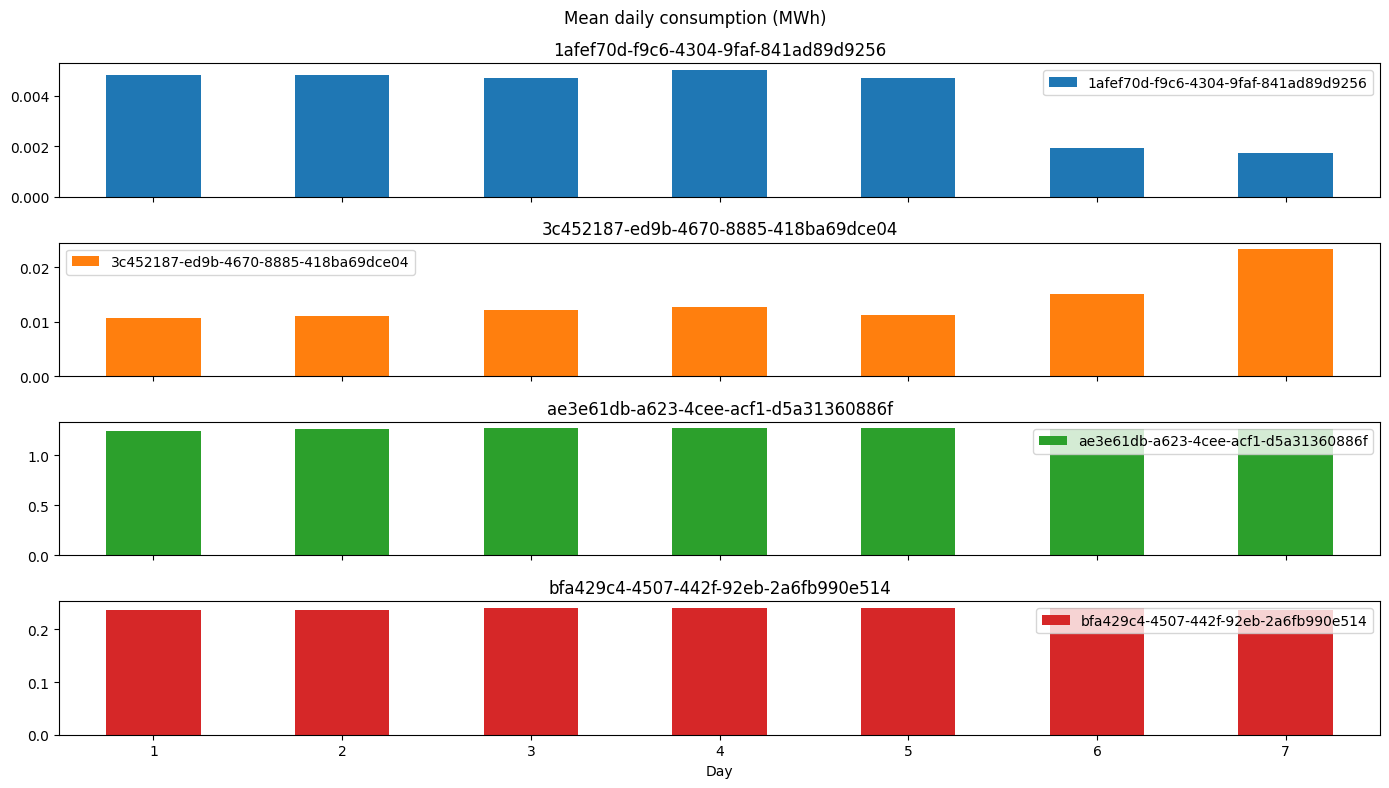

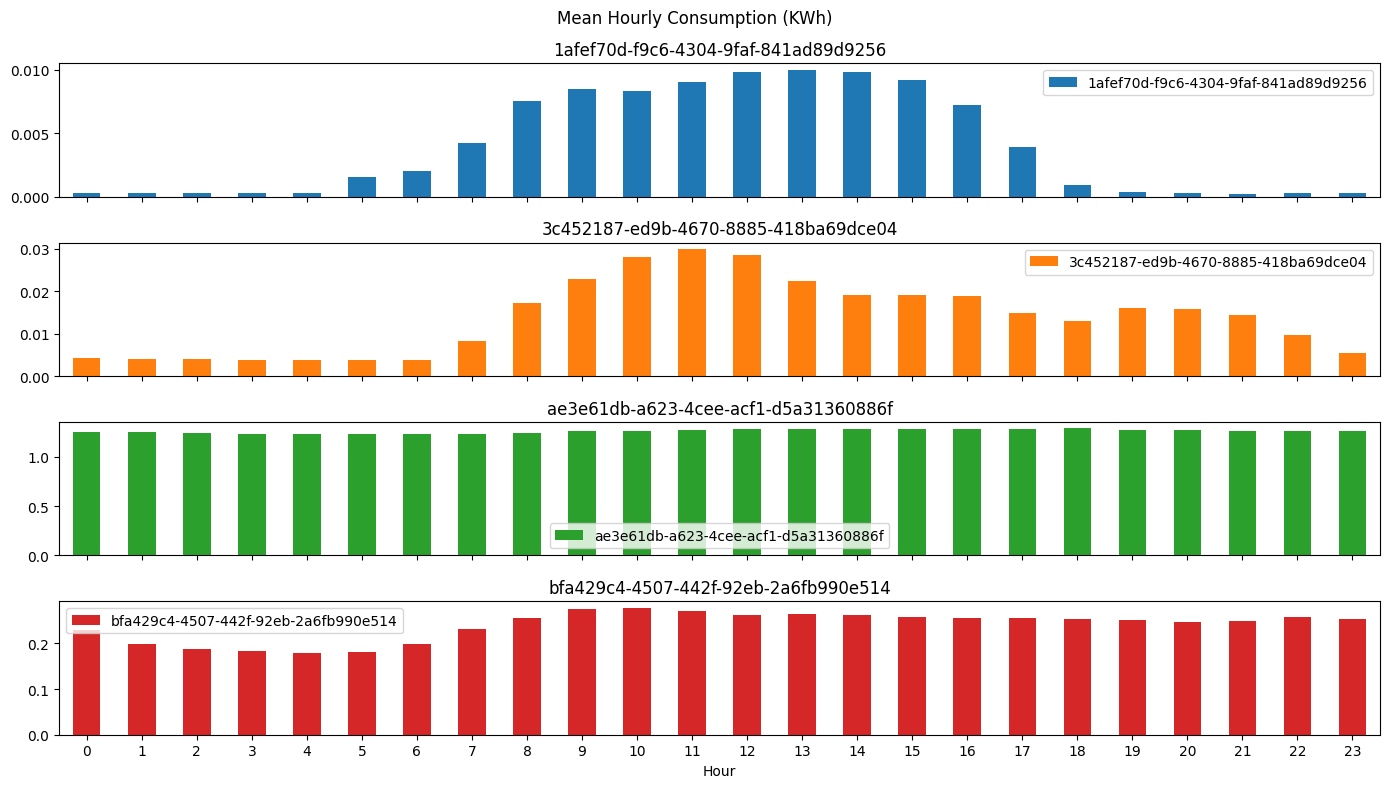

In [11]:

consumption_dow = consumption.groupby(['ConnectionId','Day']).mean().Consumption
consumption_hourly = consumption.groupby(['ConnectionId','Hour']).mean().Consumption
fig, ax = plt.subplots(1,2, figsize=(14,8))
consumption_dow.unstack(level=0).plot(kind='bar',subplots=True, rot=0, figsize=(15,10), layout=(4,1), ax=ax[0], sharex=True, title='Mean daily consumption (MWh)')
plt.tight_layout()
consumption_hourly.unstack(level=0).plot(kind='bar',subplots=True, rot=0, figsize=(14,8), layout=(4,1), title='Mean Hourly Consumption (KWh)')
plt.tight_layout()

Blue (School)

* Daily: The blue chart shows a sharp drop off during weekends, implying it is a school.
* Hourly: The load is higher during school/working hours, for example, at 7am school starts, by 6pm everyone has left.

Orange (Church)

* Daily: Consumption doubles on Sunday and small spike on Wednesday, which implies it is a Church since people go to Church on Sundays and sometimes Wednesdays.
* Hourly: Peak during morning to early afternoon when people attend church.

Green (Datacenter)

* Daily: The mean consumption is ~1200 kwH and is 5x higher than the next highest connection which is red. Then it must be the datacenter since it consumes the most power. 
* Hourly: There is very little variance across hourly load, which implies it is a datacenter as it is always running 24/7.

Red (Hotel)

* Daily: Again, very similar to green.
* Hourly: We can see a drop off in morning hours when people are sleeping, letting us infer it is a hotel.

# Q4

In [12]:
def group(df):
    return df.groupby(['Connection','Day']).Consumption

# map the consumption Id to name
keys = consumption.ConnectionId.unique()
values = ['school','church','dc','hotel']
mapping =  {k: v for k,v in zip(sorted(keys), values )}

# generate normalized prices
consumption['Connection'] = consumption['ConnectionId'].map(mapping)
n_consumption = pd.DataFrame(consumption.groupby(['Connection','Day','HalfHour'])['Consumption'].mean()).reset_index()




n_consumption['MaxNorm'] = group(n_consumption).transform(lambda x: x/x.max())
n_consumption['FracNorm'] = group(n_consumption).transform(lambda x: x/x.sum())
n_consumption['ZNorm'] = group(n_consumption).transform(lambda x: zscore(x, ddof=1))
n_consumption['std'] = group(n_consumption).transform(lambda x: x.std())



In [13]:
n_consumption

,Connection,Day,HalfHour,Consumption,MaxNorm,FracNorm,ZNorm,std
0,church,1,1,0.004014,0.181791,0.007839,-1.131898,0.005878
1,church,1,2,0.004001,0.181196,0.007814,-1.134135,0.005878
2,church,1,3,0.003801,0.172113,0.007422,-1.168251,0.005878
3,church,1,4,0.003888,0.176059,0.007592,-1.153430,0.005878
4,church,1,5,0.003942,0.178516,0.007698,-1.144202,0.005878
...,...,...,...,...,...,...,...,...
1339,school,7,44,0.000267,0.061826,0.003208,-0.910228,0.001614
1340,school,7,45,0.000281,0.064965,0.003371,-0.901816,0.001614
1341,school,7,46,0.000281,0.065072,0.003377,-0.901530,0.001614
1342,school,7,47,0.000280,0.064743,0.003360,-0.902411,0.001614


We can plot it out similar to our normalized prices:

<AxesSubplot: title={'center': 'Z Norm'}>

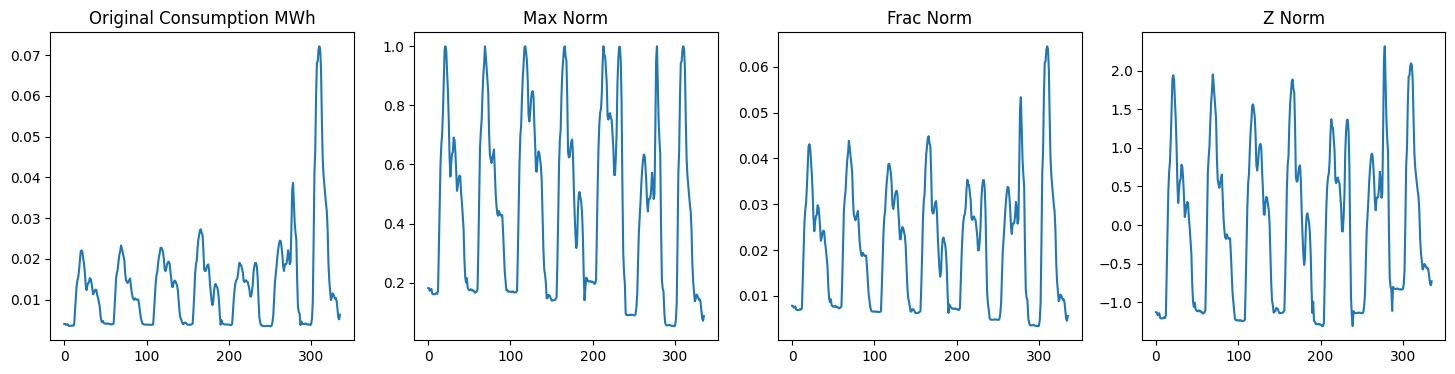

In [14]:
church = n_consumption[n_consumption.Connection=='church']
fig,ax = plt.subplots(1,4, figsize=(18,4))
church.Consumption.plot(ax=ax[0], title='Original Consumption MWh')
church.MaxNorm.plot(ax=ax[1], title='Max Norm')
church.FracNorm.plot(ax=ax[2], title= 'Frac Norm')
church.ZNorm.plot(ax=ax[3], title='Z Norm')

# Q5

> Use your normalized half hourly price curve and your half hourly consumption curve on the settlement prices and consumption volumes to create half hourly expected market prices (SGD/MWh) and half hourly expected consumption volumes (MWh) per connection
between 01-01-2024 and 31-12-2026.

 To apply the normalized half hour price curve to the settlement price:

* `MaxNorm`: I thought of baseload. I take the max-normed price, add 1 to it and multiply it by the settlement price.  
* `FracNorm`: Take settlement price, multiply by 48, then multiply by fraction.
* `ZNorm`: Use formula $x=\mu + \sigma z$ where $\mu$ is settlement price. This didn't give realistic values so I discarded this option.

To apply the half hourly consumption curve to consumption volume, I am not sure what this means, so I just took the consumption values as they were.

In [15]:
# List to store the DataFrames
ex_prices = []
ex_consumption = []

# Loop to create and append DataFrames for each year
for year in [2024, 2025, 2026]:
    df_copy = n_price.copy()
    df_copy['Year'] = year
    ex_prices.append(df_copy)

    c_copy = n_consumption.copy()
    c_copy['Year'] = year
    ex_consumption.append(c_copy)

# expected prices
ex_prices = pd.concat(ex_prices, ignore_index=True)
ex_prices = ex_prices.merge(settlements, on=['Year','Month'])

ex_prices['MaxP'] = ex_prices.SettlementPrice * (1+ ex_prices.MaxNorm)
ex_prices['FracP'] = ex_prices.SettlementPrice * 48 * 30 * ex_prices.FracNorm
ex_prices['ZP'] = ex_prices.SettlementPrice + ex_prices.ZNorm * ex_prices['std']


# expected consumption
ex_consumption = pd.concat(ex_consumption, ignore_index=True)


In [16]:
ex_prices.round(3)

,Month,Day,HalfHour,Price,MaxNorm,FracNorm,ZNorm,std,Year,SettlementPrice,Unit,MaxP,FracP,ZP
0,1,1,1,349.228,0.864,0.026,0.938,79.532,2024,165.0,SGD/MWh,307.479,6295.535,239.640
1,1,1,2,336.342,0.832,0.026,0.776,79.532,2024,165.0,SGD/MWh,302.222,6063.239,226.754
2,1,1,3,189.147,0.468,0.014,-1.074,79.532,2024,165.0,SGD/MWh,242.169,3409.754,79.559
3,1,1,4,158.491,0.392,0.012,-1.460,79.532,2024,165.0,SGD/MWh,229.662,2857.118,48.903
4,1,1,5,157.737,0.390,0.012,-1.469,79.532,2024,165.0,SGD/MWh,229.354,2843.526,48.149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12091,12,7,44,172.930,0.734,0.024,0.723,30.868,2026,140.0,SGD/MWh,242.746,4822.615,162.326
12092,12,7,45,163.004,0.692,0.023,0.402,30.868,2026,140.0,SGD/MWh,236.849,4545.814,152.400
12093,12,7,46,151.040,0.641,0.021,0.014,30.868,2026,140.0,SGD/MWh,229.740,4212.154,140.436
12094,12,7,47,151.279,0.642,0.021,0.022,30.868,2026,140.0,SGD/MWh,229.882,4218.816,140.675


In [17]:
ex_consumption.round(3)

,Connection,Day,HalfHour,Consumption,MaxNorm,FracNorm,ZNorm,std,Year
0,church,1,1,0.004,0.182,0.008,-1.132,0.006,2024
1,church,1,2,0.004,0.181,0.008,-1.134,0.006,2024
2,church,1,3,0.004,0.172,0.007,-1.168,0.006,2024
3,church,1,4,0.004,0.176,0.008,-1.153,0.006,2024
4,church,1,5,0.004,0.179,0.008,-1.144,0.006,2024
...,...,...,...,...,...,...,...,...,...
4027,school,7,44,0.000,0.062,0.003,-0.910,0.002,2026
4028,school,7,45,0.000,0.065,0.003,-0.902,0.002,2026
4029,school,7,46,0.000,0.065,0.003,-0.902,0.002,2026
4030,school,7,47,0.000,0.065,0.003,-0.902,0.002,2026


I multiply expected prices $SGD/MWh$ by Consumption $MWh$ gives the half-hourly cost in $SGD$ for each connection using both `MaxP` and `FracP`:

In [18]:

def create_costs(ex_prices, ex_consumption, method):
    for c in ex_consumption.Connection.unique().tolist():
        ex_prices = ex_prices.merge(ex_consumption[ex_consumption.Connection==c][['Year','Day','HalfHour','Consumption']], on=['Year','Day','HalfHour'])
        if method == 'MaxP':
            ex_prices['Consumption'] = ex_prices.Consumption * ex_prices.MaxP
        if method == 'FracP':
            ex_prices['Consumption'] = ex_prices.Consumption * ex_prices.FracP

        ex_prices = ex_prices.rename(columns={'Consumption':c})    
    return ex_prices

max_costs = create_costs(ex_prices, ex_consumption, 'MaxP')
frac_costs = create_costs(ex_prices, ex_consumption, 'FracP')

    

In [19]:
max_costs

,Month,Day,HalfHour,Price,MaxNorm,FracNorm,ZNorm,std,Year,SettlementPrice,Unit,MaxP,FracP,ZP,church,dc,hotel,school
0,1,1,1,349.228000,0.863511,0.026496,0.938495,79.531558,2024,165.0,SGD/MWh,307.479304,6295.534902,239.639958,1.234298,384.982176,65.623517,0.071720
1,2,1,1,168.395000,0.236595,0.012281,-0.842793,139.154803,2024,165.0,SGD/MWh,204.038241,2917.858144,47.721328,0.819060,255.467880,43.546693,0.047592
2,3,1,1,236.113750,0.350523,0.013457,-0.836685,154.696600,2024,165.0,SGD/MWh,222.836223,3197.307396,35.567708,0.894520,279.004059,47.558637,0.051977
3,4,1,1,192.640000,0.131333,0.009782,-0.709070,306.947109,2024,165.0,SGD/MWh,186.669938,2324.148824,-52.646979,0.749339,233.721743,39.839878,0.043541
4,5,1,1,653.374000,0.911321,0.036021,1.657225,166.232080,2024,165.0,SGD/MWh,315.367890,8558.576328,440.483896,1.265964,394.859150,67.307132,0.073560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12091,8,7,48,141.973750,0.356914,0.015283,-0.965033,53.427083,2026,140.0,SGD/MWh,189.967979,3081.081208,88.441120,1.192695,237.776587,47.022856,0.046268
12092,9,7,48,169.370000,0.599922,0.017345,-0.937042,36.348828,2026,140.0,SGD/MWh,223.989090,3496.793168,105.939609,1.406293,280.359678,55.444117,0.054554
12093,10,7,48,165.961000,0.274098,0.015808,-0.446484,118.155187,2026,140.0,SGD/MWh,178.373690,3186.955042,87.245583,1.119901,223.264402,44.152917,0.043444
12094,11,7,48,172.318750,0.293886,0.010744,-1.094780,147.798075,2026,140.0,SGD/MWh,181.143991,2166.071154,-21.806354,1.137294,226.731896,44.838651,0.044119


>Combine these to arrive at each connection’s monthly expected energy costs between 01-01-2024 and 31-12-2026 for each of these customers.

In [20]:
max_month = max_costs.groupby(['Year','Month'])[['church','dc','hotel','school']].sum().round(2)
frac_month = frac_costs.groupby(['Year','Month'])[['church','dc','hotel','school']].sum().round(2)

In [21]:
2500 * 165

412500

In [34]:
max_month.T

Year         2024                                                         \
Month          1          2          3          4          5          6    
church    1193.35    1182.57    1151.25    1124.93    1184.59    1145.05   
dc      106930.29  105131.39  102337.42   98547.49  107209.99  102786.69   
hotel    20476.58   20150.26   19610.68   18830.80   20476.92   19653.92   
school     355.50     357.14     340.07     315.98     352.65     333.23   
2Y      128955.72  126821.36  123439.42  118819.20  129224.15  123918.89   
3Y      108479.14  106671.10  103828.74   99988.40  108747.23  104264.97   

Year                                                ...       2026             \
Month          7          8          9          10  ...         3          4    
church    1120.96    1167.24    1128.04    1076.70  ...     976.82     954.49   
dc      102429.12  105036.33   98038.41   97485.87  ...   86831.75   83616.05   
hotel    19593.39   20058.88   18728.13   18640.23  ...   16639.36   15977.65   
school     341.71     346.92     305.65     318.56  ...     288.55     268.10   
2Y      123485.18  126609.37  118200.23  117521.36  ...  104736.48  100816.29   
3Y      103891.79  106550.49   99472.10   98881.13  ...   88097.12   84838.64   

Year                                                                      \
Month          5          6          7          8          9          10   
church    1005.11     971.56    1010.78    1052.51    1017.17     970.87   
dc       90966.05   87212.95   92361.70   94712.65   88402.53   87904.30   
hotel    17374.35   16676.05   17667.62   18087.36   16887.41   16808.14   
school     299.22     282.74     308.12     312.82     275.61     287.25   
2Y      109644.73  105143.30  111348.22  114165.34  106582.72  105970.56   
3Y       92270.38   88467.25   93680.60   96077.98   89695.31   89162.42   

Year                          
Month          11         12  
church     983.40    1080.58  
dc       86843.32   95557.91  
hotel    16578.53   18270.83  
school     277.97     311.64  
2Y      104683.22  115220.96  
3Y       88104.69   96950.13  

[6 rows x 36 columns]

In [23]:
frac_month/30

church            dc         hotel      school
Year Month                                                    
2024 1      833.716000  70216.432000  13692.417333  245.415000
     2      852.491333  70237.467000  13761.026333  259.882000
     3      849.646000  70222.984000  13760.465667  258.513333
     4      847.415000  70309.578333  13738.546667  257.207333
     5      815.517333  70138.084667  13585.077667  241.377333
     6      829.463667  70249.270333  13695.076333  233.699667
     7      751.294000  66041.231333  12836.312667  228.257667
     8      778.714000  65968.251333  12767.815333  231.940000
     9      788.864333  66021.408667  12840.890333  227.280000
     10     777.324333  66079.180667  12859.553000  226.187667
     11     780.261000  66083.050333  12828.596667  230.347000
     12     783.339333  66036.378000  12810.888333  237.364000
2025 1      757.923667  63833.120000  12447.652000  223.104667
     2      774.992000  63852.242667  12510.024000  236.256333
     3      772.405667  63839.076333  12509.514333  235.012333
     4      770.377333  63917.798333  12489.587667  233.825000
     5      741.379333  63761.895333  12350.070667  219.434000
     6      754.057667  63862.973000  12450.069333  212.454333
     7      725.841333  63803.843000  12401.435667  220.524667
     8      752.332333  63733.335667  12335.259000  224.082333
     9      762.138667  63784.692000  12405.858000  219.580000
     10     750.989667  63840.507000  12423.888667  218.524667
     11     753.827000  63844.245333  12393.981000  222.543333
     12     756.800667  63799.154333  12376.872667  229.322333
2026 1      707.395333  59577.578667  11617.808667  208.231000
     2      723.326000  59595.426667  11676.022333  220.506000
     3      720.912000  59583.138000  11675.546667  219.344667
     4      719.019000  59656.612000  11656.948667  218.236667
     5      691.954000  59511.102333  11526.732333  204.805000
     6      703.787333  59605.441667  11620.064667  198.290667
     7      677.451667  59550.253667  11574.673333  205.823000
     8      702.176667  59484.446667  11512.908333  209.143667
     9      711.329333  59532.379333  11578.801000  204.941333
     10     700.923667  59584.473333  11595.629333  203.956333
     11     703.571667  59587.962333  11567.715667  207.707000
     12     706.347333  59545.877333  11551.748000  214.034333

> Calculate the assumed costs per MWh for each connection vs the average settlement monthly price, and the difference value (delta) between the two. What does a high delta indicate?

A high delta indicates a large difference in the cost of electricity for that connection for that month and the cost of 1 MWH of electricity from the settlement.



In [24]:
max_mean_cost = max_costs.groupby(['Year','Month'])[['church','dc','hotel','school', 'SettlementPrice']].mean().round(2)
frac_mean_cost = frac_costs.groupby(['Year','Month'])[['church','dc','hotel','school', "SettlementPrice"]].mean().round(2)
max_mean_cost

church      dc  hotel  school  SettlementPrice
Year Month                                                
2024 1        3.55  318.24  60.94    1.06           165.00
     2        3.52  312.89  59.97    1.06           165.00
     3        3.43  304.58  58.37    1.01           165.00
     4        3.35  293.30  56.04    0.94           165.00
     5        3.53  319.08  60.94    1.05           165.00
     6        3.41  305.91  58.49    0.99           165.00
     7        3.34  304.85  58.31    1.02           155.26
     8        3.47  312.61  59.70    1.03           155.26
     9        3.36  291.78  55.74    0.91           155.26
     10       3.20  290.14  55.48    0.95           155.26
     11       3.25  286.63  54.72    0.92           155.26
     12       3.57  315.40  60.30    1.03           155.26
2025 1        3.23  289.31  55.40    0.96           150.00
     2        3.20  284.45  54.52    0.97           150.00
     3        3.11  276.89  53.06    0.92           150.00
     4        3.04  266.63  50.95    0.85           150.00
     5        3.21  290.07  55.40    0.95           150.00
     6        3.10  278.10  53.18    0.90           150.00
     7        3.22  294.52  56.34    0.98           150.00
     8        3.36  302.02  57.68    1.00           150.00
     9        3.24  281.90  53.85    0.88           150.00
     10       3.10  280.31  53.60    0.92           150.00
     11       3.14  276.92  52.87    0.89           150.00
     12       3.45  304.71  58.26    0.99           150.00
2026 1        3.01  270.03  51.71    0.90           140.00
     2        2.99  265.48  50.88    0.90           140.00
     3        2.91  258.43  49.52    0.86           140.00
     4        2.84  248.86  47.55    0.80           140.00
     5        2.99  270.73  51.71    0.89           140.00
     6        2.89  259.56  49.63    0.84           140.00
     7        3.01  274.89  52.58    0.92           140.00
     8        3.13  281.88  53.83    0.93           140.00
     9        3.03  263.10  50.26    0.82           140.00
     10       2.89  261.62  50.02    0.85           140.00
     11       2.93  258.46  49.34    0.83           140.00
     12       3.22  284.40  54.38    0.93           140.00

In [26]:
max_mean_cost.sub(max_mean_cost.SettlementPrice,axis=0)

church      dc   hotel  school  SettlementPrice
Year Month                                                 
2024 1     -161.45  153.24 -104.06 -163.94              0.0
     2     -161.48  147.89 -105.03 -163.94              0.0
     3     -161.57  139.58 -106.63 -163.99              0.0
     4     -161.65  128.30 -108.96 -164.06              0.0
     5     -161.47  154.08 -104.06 -163.95              0.0
     6     -161.59  140.91 -106.51 -164.01              0.0
     7     -151.92  149.59  -96.95 -154.24              0.0
     8     -151.79  157.35  -95.56 -154.23              0.0
     9     -151.90  136.52  -99.52 -154.35              0.0
     10    -152.06  134.88  -99.78 -154.31              0.0
     11    -152.01  131.37 -100.54 -154.34              0.0
     12    -151.69  160.14  -94.96 -154.23              0.0
2025 1     -146.77  139.31  -94.60 -149.04              0.0
     2     -146.80  134.45  -95.48 -149.03              0.0
     3     -146.89  126.89  -96.94 -149.08              0.0
     4     -146.96  116.63  -99.05 -149.15              0.0
     5     -146.79  140.07  -94.60 -149.05              0.0
     6     -146.90  128.10  -96.82 -149.10              0.0
     7     -146.78  144.52  -93.66 -149.02              0.0
     8     -146.64  152.02  -92.32 -149.00              0.0
     9     -146.76  131.90  -96.15 -149.12              0.0
     10    -146.90  130.31  -96.40 -149.08              0.0
     11    -146.86  126.92  -97.13 -149.11              0.0
     12    -146.55  154.71  -91.74 -149.01              0.0
2026 1     -136.99  130.03  -88.29 -139.10              0.0
     2     -137.01  125.48  -89.12 -139.10              0.0
     3     -137.09  118.43  -90.48 -139.14              0.0
     4     -137.16  108.86  -92.45 -139.20              0.0
     5     -137.01  130.73  -88.29 -139.11              0.0
     6     -137.11  119.56  -90.37 -139.16              0.0
     7     -136.99  134.89  -87.42 -139.08              0.0
     8     -136.87  141.88  -86.17 -139.07              0.0
     9     -136.97  123.10  -89.74 -139.18              0.0
     10    -137.11  121.62  -89.98 -139.15              0.0
     11    -137.07  118.46  -90.66 -139.17              0.0
     12    -136.78  144.40  -85.62 -139.07              0.0

# Q6

> Assuming a 2-year contract for the hotel, and 3-year contracts for the remaining connections starting 1-1-2024, calculate how much energy we would have to buy in total per month for this small retail portfolio

The monthly energy for the first two years is in the 2Y column, and for the last year is in the 3Y column (starting from 2026).


In [27]:
max_month['2Y'] = max_month.sum(axis=1)
max_month['3Y'] = max_month['2Y'].sub(max_month.hotel)

frac_month['2Y'] = frac_month.sum(axis=1)
frac_month['3Y'] = frac_month['2Y'].sub(frac_month.hotel)


In [28]:
max_month

church         dc     hotel  school         2Y         3Y
Year Month                                                            
2024 1      1193.35  106930.29  20476.58  355.50  128955.72  108479.14
     2      1182.57  105131.39  20150.26  357.14  126821.36  106671.10
     3      1151.25  102337.42  19610.68  340.07  123439.42  103828.74
     4      1124.93   98547.49  18830.80  315.98  118819.20   99988.40
     5      1184.59  107209.99  20476.92  352.65  129224.15  108747.23
     6      1145.05  102786.69  19653.92  333.23  123918.89  104264.97
     7      1120.96  102429.12  19593.39  341.71  123485.18  103891.79
     8      1167.24  105036.33  20058.88  346.92  126609.37  106550.49
     9      1128.04   98038.41  18728.13  305.65  118200.23   99472.10
     10     1076.70   97485.87  18640.23  318.56  117521.36   98881.13
     11     1090.59   96309.24  18385.59  308.27  116093.69   97708.10
     12     1198.37  105973.72  20262.35  345.61  127780.05  107517.70
2025 1      1084.86   97209.35  18615.07  323.18  117232.46   98617.39
     2      1075.06   95573.99  18318.42  324.67  115292.14   96973.72
     3      1046.59   93034.01  17827.89  309.16  112217.65   94389.76
     4      1022.67   89588.62  17118.91  287.25  108017.45   90898.54
     5      1076.90   97463.63  18615.38  320.59  117476.50   98861.12
     6      1040.96   93442.44  17867.20  302.94  112653.54   94786.34
     7      1082.98   98958.96  18929.59  330.13  119301.66  100372.07
     8      1127.69  101477.84  19379.31  335.16  122320.00  102940.69
     9      1089.83   94717.00  18093.65  295.29  114195.77   96102.12
     10     1040.22   94183.18  18008.73  307.77  113539.90   95531.17
     11     1053.64   93046.42  17762.71  297.82  112160.59   94397.88
     12     1157.77  102383.48  19575.88  333.90  123451.03  103875.15
2026 1      1012.54   90728.73  17374.07  301.64  109416.98   92042.91
     2      1003.39   89202.39  17097.19  303.03  107606.00   90508.81
     3       976.82   86831.75  16639.36  288.55  104736.48   88097.12
     4       954.49   83616.05  15977.65  268.10  100816.29   84838.64
     5      1005.11   90966.05  17374.35  299.22  109644.73   92270.38
     6       971.56   87212.95  16676.05  282.74  105143.30   88467.25
     7      1010.78   92361.70  17667.62  308.12  111348.22   93680.60
     8      1052.51   94712.65  18087.36  312.82  114165.34   96077.98
     9      1017.17   88402.53  16887.41  275.61  106582.72   89695.31
     10      970.87   87904.30  16808.14  287.25  105970.56   89162.42
     11      983.40   86843.32  16578.53  277.97  104683.22   88104.69
     12     1080.58   95557.91  18270.83  311.64  115220.96   96950.13

In [29]:
frac_month

church          dc      hotel   school          2Y          3Y
Year Month                                                                  
2024 1      25011.48  2106492.96  410772.52  7362.45  2549639.41  2138866.89
     2      25574.74  2107124.01  412830.79  7796.46  2553326.00  2140495.21
     3      25489.38  2106689.52  412813.97  7755.40  2552748.27  2139934.30
     4      25422.45  2109287.35  412156.40  7716.22  2554582.42  2142426.02
     5      24465.52  2104142.54  407552.33  7241.32  2543401.71  2135849.38
     6      24883.91  2107478.11  410852.29  7010.99  2550225.30  2139373.01
     7      22538.82  1981236.94  385089.38  6847.73  2395712.87  2010623.49
     8      23361.42  1979047.54  383034.46  6958.20  2392401.62  2009367.16
     9      23665.93  1980642.26  385226.71  6818.40  2396353.30  2011126.59
     10     23319.73  1982375.42  385786.59  6785.63  2398267.37  2012480.78
     11     23407.83  1982491.51  384857.90  6910.41  2397667.65  2012809.75
     12     23500.18  1981091.34  384326.65  7120.92  2396039.09  2011712.44
2025 1      22737.71  1914993.60  373429.56  6693.14  2317854.01  1944424.45
     2      23249.76  1915567.28  375300.72  7087.69  2321205.45  1945904.73
     3      23172.17  1915172.29  375285.43  7050.37  2320680.26  1945394.83
     4      23111.32  1917533.95  374687.63  7014.75  2322347.65  1947660.02
     5      22241.38  1912856.86  370502.12  6583.02  2312183.38  1941681.26
     6      22621.73  1915889.19  373502.08  6373.63  2318386.63  1944884.55
     7      21775.24  1914115.29  372043.07  6615.74  2314549.34  1942506.27
     8      22569.97  1912000.07  370057.77  6722.47  2311350.28  1941292.51
     9      22864.16  1913540.76  372175.74  6587.40  2315168.06  1942992.32
     10     22529.69  1915215.21  372716.66  6555.74  2317017.30  1944300.64
     11     22614.81  1915327.36  371819.43  6676.30  2316437.90  1944618.47
     12     22704.02  1913974.63  371306.18  6879.67  2314864.50  1943558.32
2026 1      21221.86  1787327.36  348534.26  6246.93  2163330.41  1814796.15
     2      21699.78  1787862.80  350280.67  6615.18  2166458.43  1816177.76
     3      21627.36  1787494.14  350266.40  6580.34  2165968.24  1815701.84
     4      21570.57  1789698.36  349708.46  6547.10  2167524.49  1817816.03
     5      20758.62  1785333.07  345801.97  6144.15  2158037.81  1812235.84
     6      21113.62  1788163.25  348601.94  5948.72  2163827.53  1815225.59
     7      20323.55  1786507.61  347240.20  6174.69  2160246.05  1813005.85
     8      21065.30  1784533.40  345387.25  6274.31  2157260.26  1811873.01
     9      21339.88  1785971.38  347364.03  6148.24  2160823.53  1813459.50
     10     21027.71  1787534.20  347868.88  6118.69  2162549.48  1814680.60
     11     21107.15  1787638.87  347031.47  6231.21  2162008.70  1814977.23
     12     21190.42  1786376.32  346552.44  6421.03  2160540.21  1813987.77

# Additonal Data Exploration

I also did some additional data analysis and exploration below. First I plot the spot prices and demand over time and as a histogram. I note the exponentially distributed shaped histogram.

<AxesSubplot: title={'center': 'histogram'}, ylabel='Frequency'>

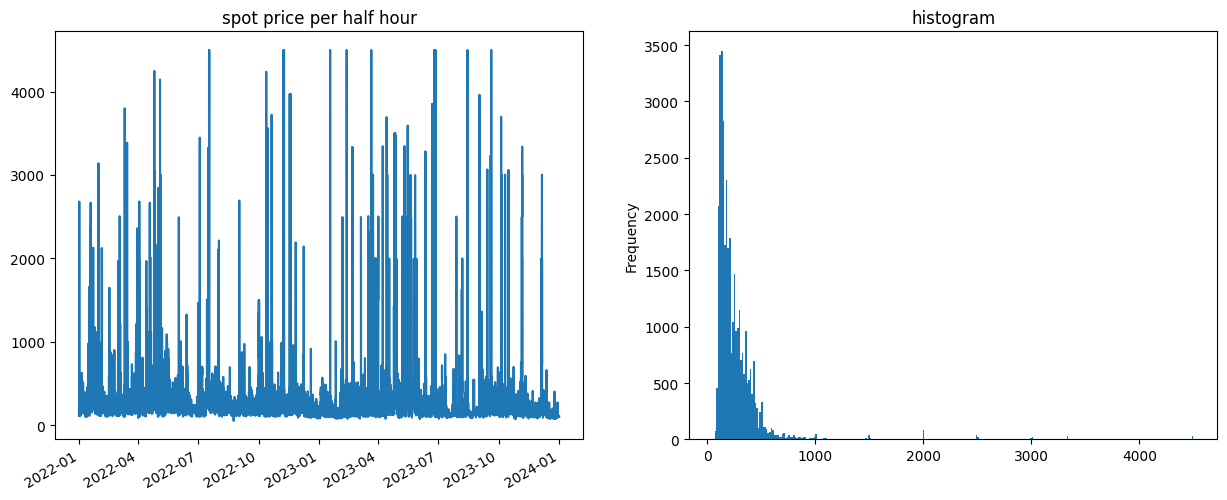

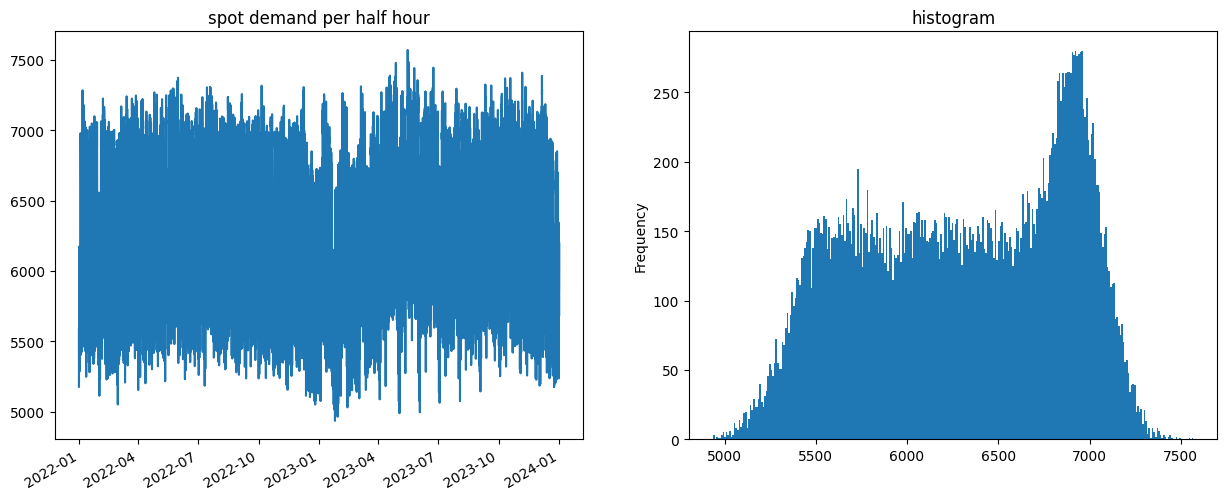

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

spot.Price.plot(ax=ax[0], title='spot price per half hour')
spot.Price.plot(kind='hist',bins=300, ax=ax[1], title='histogram')


fig, ax = plt.subplots(1,2, figsize=(15,6))
spot.TotalSystemDemandMW.plot(ax=ax[0], title='spot demand per half hour')
spot.TotalSystemDemandMW.plot(kind='hist',bins=300, ax=ax[1], title='histogram')

I also decompose the demand series using an STL decomposition. However, this doesn't tell us much.

In [31]:
import statsmodels.api as sm
# Perform the STL decomposition
spot = spot.asfreq('0.5H')
stl = sm.tsa.STL(spot['TotalSystemDemandMW'], period=600)  # You can adjust the seasonal parameter as needed
# result = stl.fit()

In [32]:
import matplotlib.pyplot as plt

# Plot the components
# plt.figure(figsize=(15, 10))
# plt.subplot(411)
# plt.plot(result.trend)
# plt.title('Trend Component')
# plt.subplot(412)
# plt.plot(result.seasonal)
# plt.title('Seasonal Component')
# plt.subplot(413)
# plt.plot(result.resid)
# plt.title('Residual Component')
# plt.subplot(414)
# plt.plot(spot['TotalSystemDemandMW'])
# plt.title('Original Time Series')
# plt.tight_layout()
# plt.show()

I then look at how demand and price looks like on an hourly, year-month and monthly basis. 

<AxesSubplot: title={'center': 'Average Prices (MWh) per month '}, xlabel='Month'>

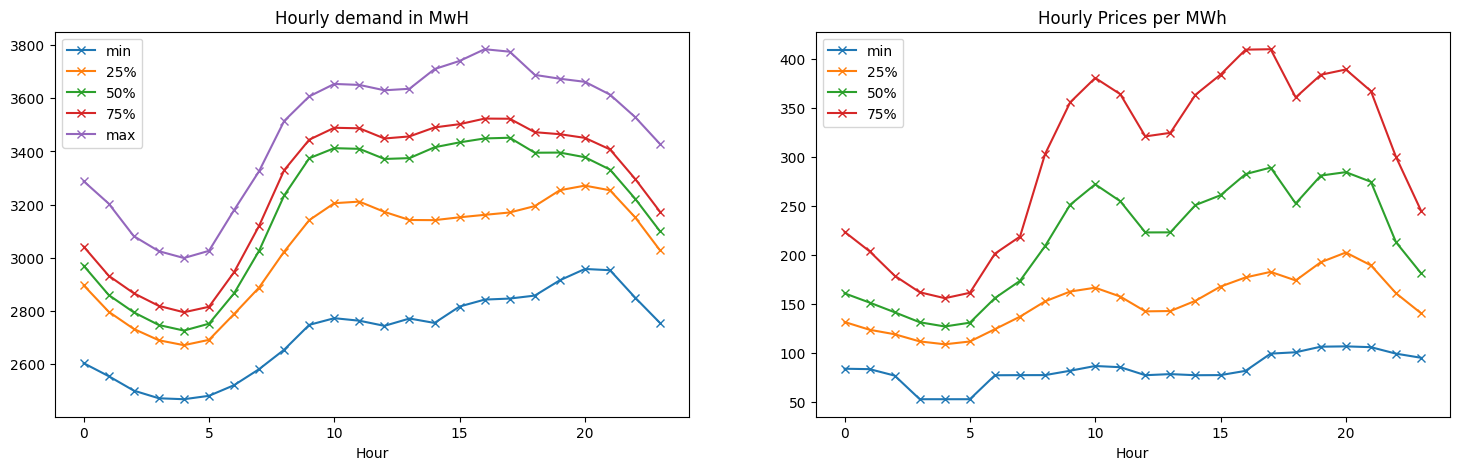

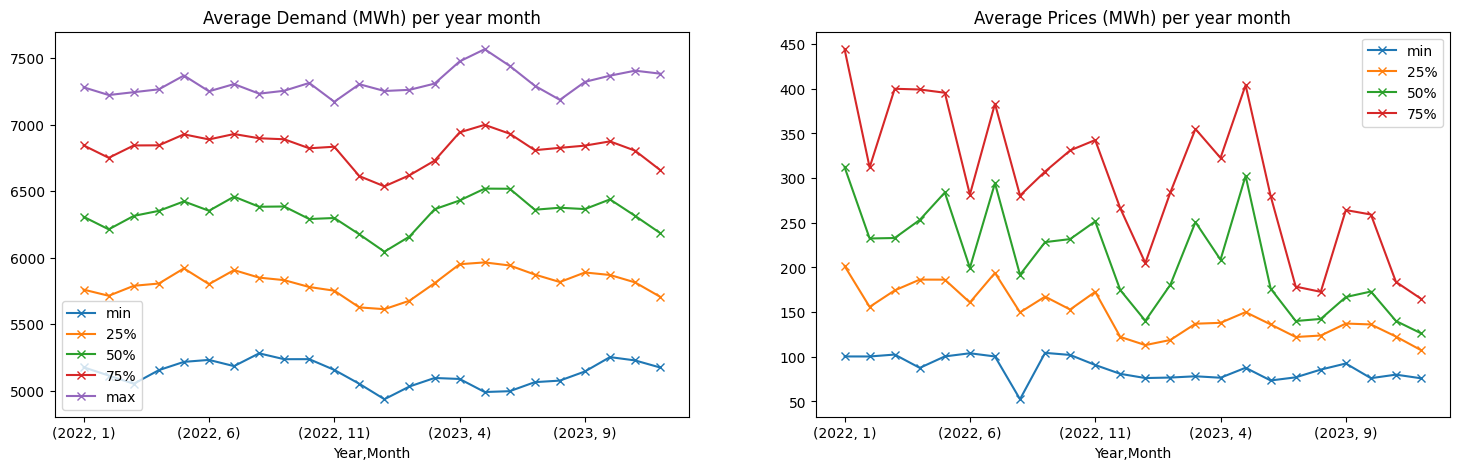

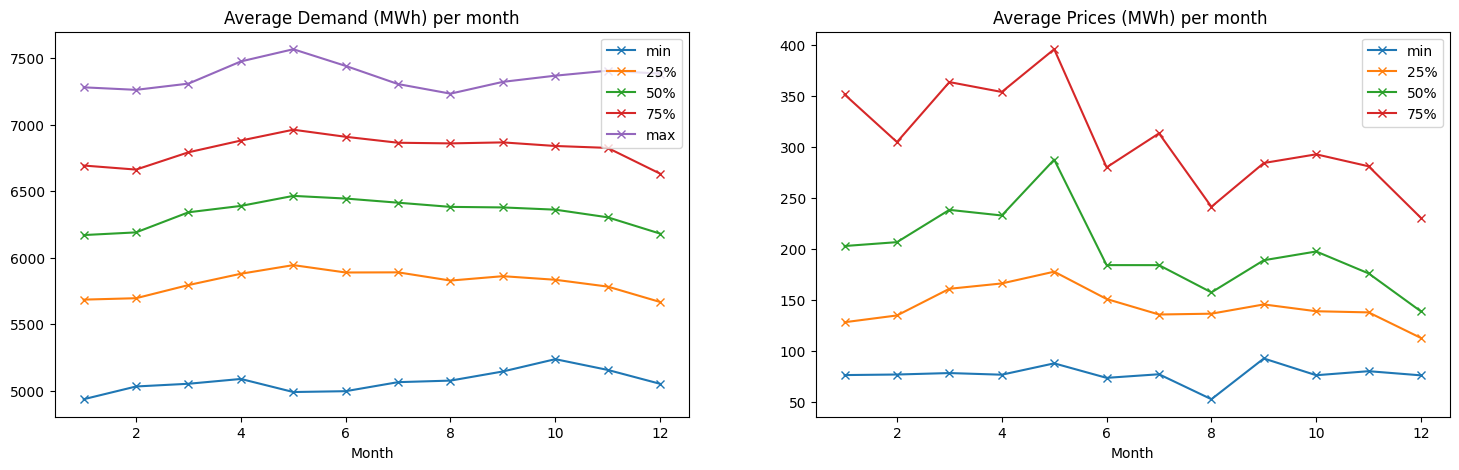

In [33]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
spot.groupby('Hour')['TotalSystemDemandMWh'].describe().iloc[:, 3:].plot(marker='x', ax=ax[0], title='Hourly demand in MwH')
spot.groupby(['Hour'])['Price'].describe().iloc[:,3:-1].plot(marker='x', ax=ax[1], title='Hourly Prices per MWh')

fig, ax = plt.subplots(1,2, figsize=(18,5))
spot.groupby(['Year', 'Month'])['TotalSystemDemandMW'].describe().iloc[:, 3:].plot(marker='x', ax=ax[0], title='Average Demand (MWh) per year month')
spot.groupby(['Year', 'Month'])['Price'].describe().iloc[:,3:-1].plot(marker='x', ax=ax[1], title='Average Prices (MWh) per year month')

fig, ax = plt.subplots(1,2, figsize=(18,5))
spot.groupby(['Month'])['TotalSystemDemandMW'].describe().iloc[:, 3:].plot(marker='x', ax=ax[0], title='Average Demand (MWh) per month')
spot.groupby(['Month'])['Price'].describe().iloc[:,3:-1].plot(marker='x', ax=ax[1], title='Average Prices (MWh) per month ')